In [1]:
import librosa
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from src.song import Song
import librosa.display
from src.visualization import *

In [2]:
from src.database import Database
db = Database('./data/', ['classical', 'jazz', 'rock', 'hiphop', 'reggae', 'country', 'metal'], 30)

In [3]:
db.calculate_index()

In [4]:
other_song = Song('./data/blues/blues.00000.wav')

In [5]:
db.calculate_distances(other_song)

{'classical': 588666.5989749361,
 'jazz': 510855.9700465006,
 'rock': 411334.53760090616,
 'hiphop': 458283.68897095614,
 'reggae': 467351.8843108692,
 'country': 472682.90742706385,
 'metal': 414865.9675291996}

In [6]:
vis = Visualizer(db)

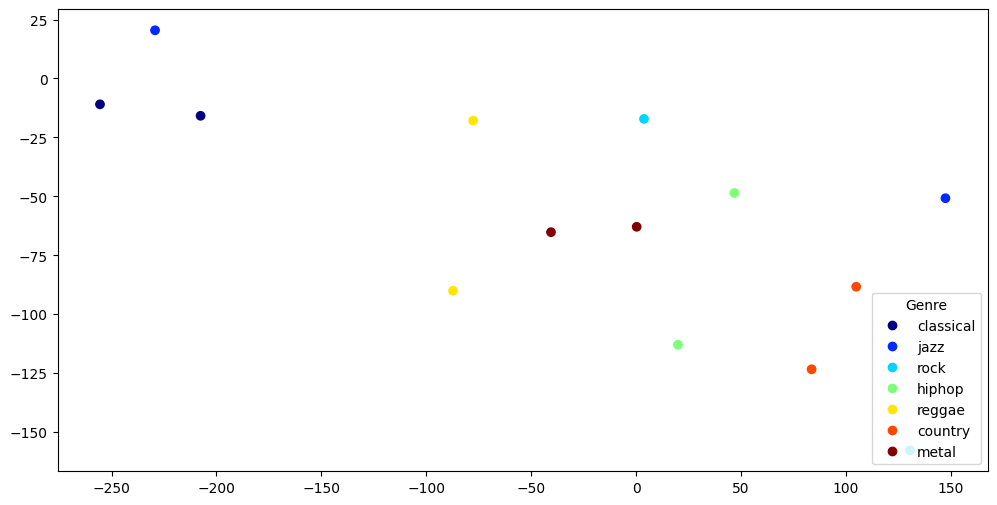

In [7]:
vis.visualize_barycenters()

In [ ]:
db.songs['blues-0'].mfcc

In [ ]:
db.songs['blues-59']

In [2]:
y, sr = librosa.load('./data/blues/blues.00000.wav')
mfcc = librosa.feature.mfcc(y=y, sr=sr)

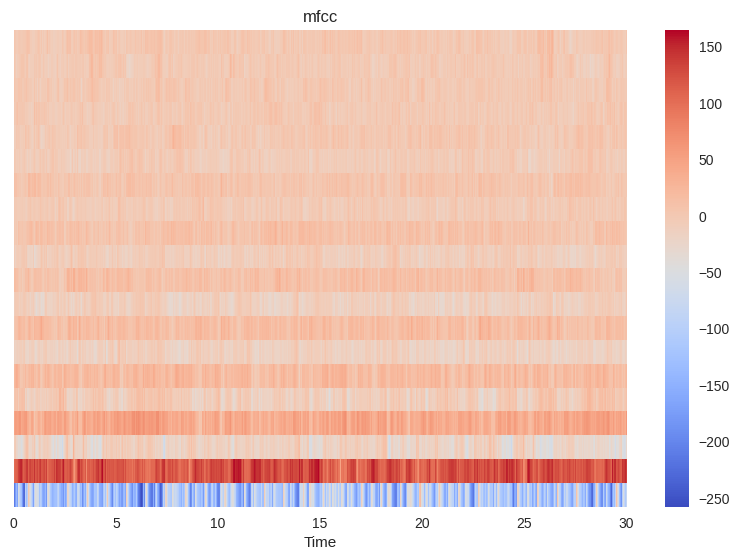

In [77]:
librosa.display.specshow(mfcc, x_axis='time')
plt.colorbar()
plt.tight_layout()
plt.title('mfcc')
plt.show()

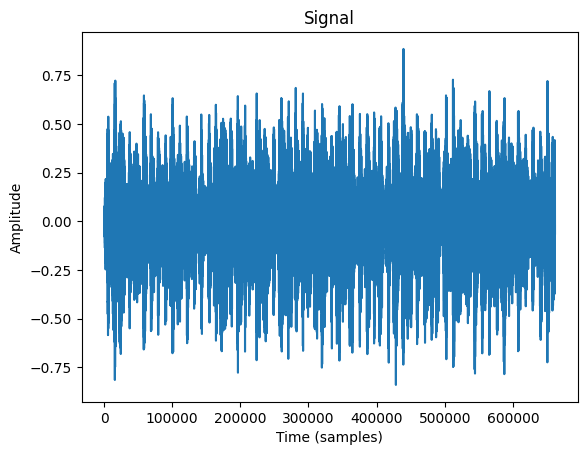

In [43]:
plt.plot(y)
plt.title('Signal')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.show()

Text(0, 0.5, 'Amplitude')

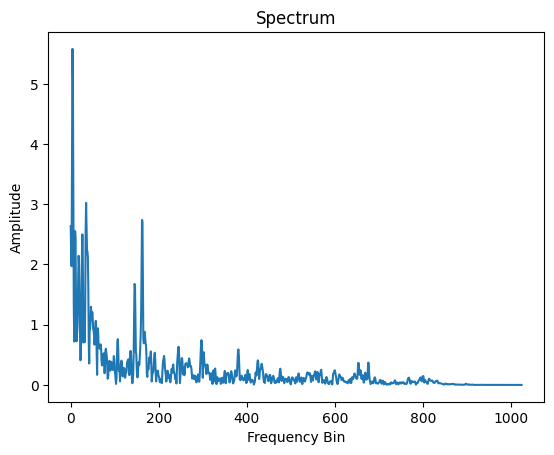

In [47]:
n_fft = 2048
ft = np.abs(librosa.stft(y[:n_fft], hop_length = n_fft+1))
plt.plot(ft)
plt.title('Spectrum')
plt.xlabel('Frequency Bin')
plt.ylabel('Amplitude')

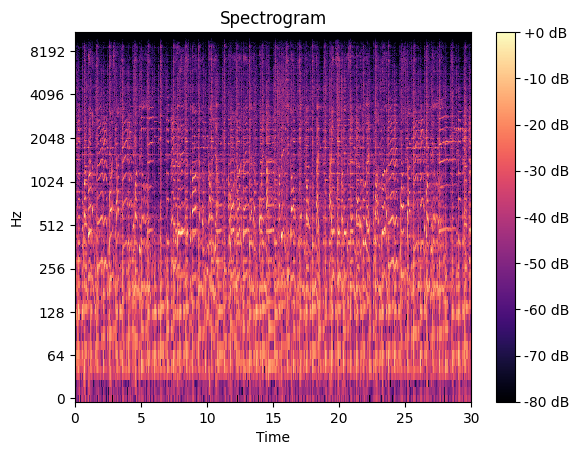

In [54]:
spec = np.abs(librosa.stft(y, hop_length=512))
spec = librosa.amplitude_to_db(spec, ref=np.max)
librosa.display.specshow(spec, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.show()

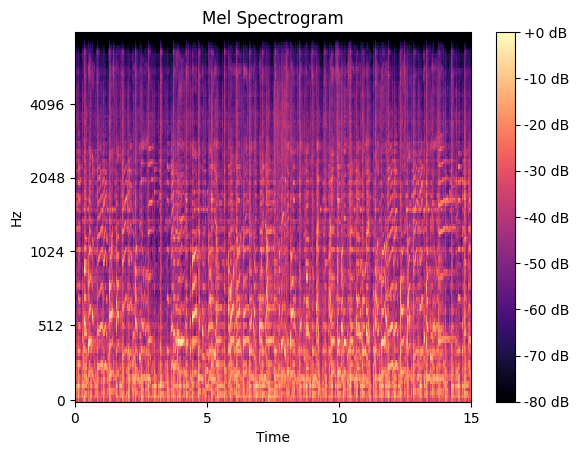

In [56]:
mel_spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=1024)
mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
librosa.display.specshow(mel_spect, y_axis='mel', fmax=8000, x_axis='time')
plt.title('Mel Spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.show()

In [3]:
y, sr = librosa.load('./data/blues/blues.00000.wav')
mfcc1 = librosa.feature.mfcc(y=y, sr=sr)
y, sr = librosa.load('./data/blues/blues.00001.wav')
mfcc2 = librosa.feature.mfcc(y=y, sr=sr)

In [4]:
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
distance, path = fastdtw(mfcc1, mfcc2, dist=euclidean)
print(distance)

15737.021979895973


In [43]:
from sklearn.manifold import TSNE

def time_warp_dist(x, y):
    distance, path = fastdtw(x, y, dist=euclidean)
    return distance

def tsne_reduce(df: pd.DataFrame, perplexity: int = 30) -> pd.DataFrame:
    """
    Reduces the dataset into 2 dimensions using t-SNE dimensionality reduction
    :param perplexity: Perplexity of t-SNE dimensionality reduction
    :param df: Dataset of learned representations
    :return: Learned representations reduced to 2 dimensions
    """
    feature_cols = [x for x in df.columns if isinstance(x, int)]
    x = df.loc[:, feature_cols]
    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=200, square_distances=True,
                init='random', metric=lambda x, y: time_warp_dist(x, y))
    tsne_results = tsne.fit_transform(x)
    cols = [f"t-SNE axe {col + 1}" for col in range(2)]
    tsne_df = pd.DataFrame(data=tsne_results, columns=cols)
    return pd.concat([tsne_df, df[['token', 'language']]], axis=1)

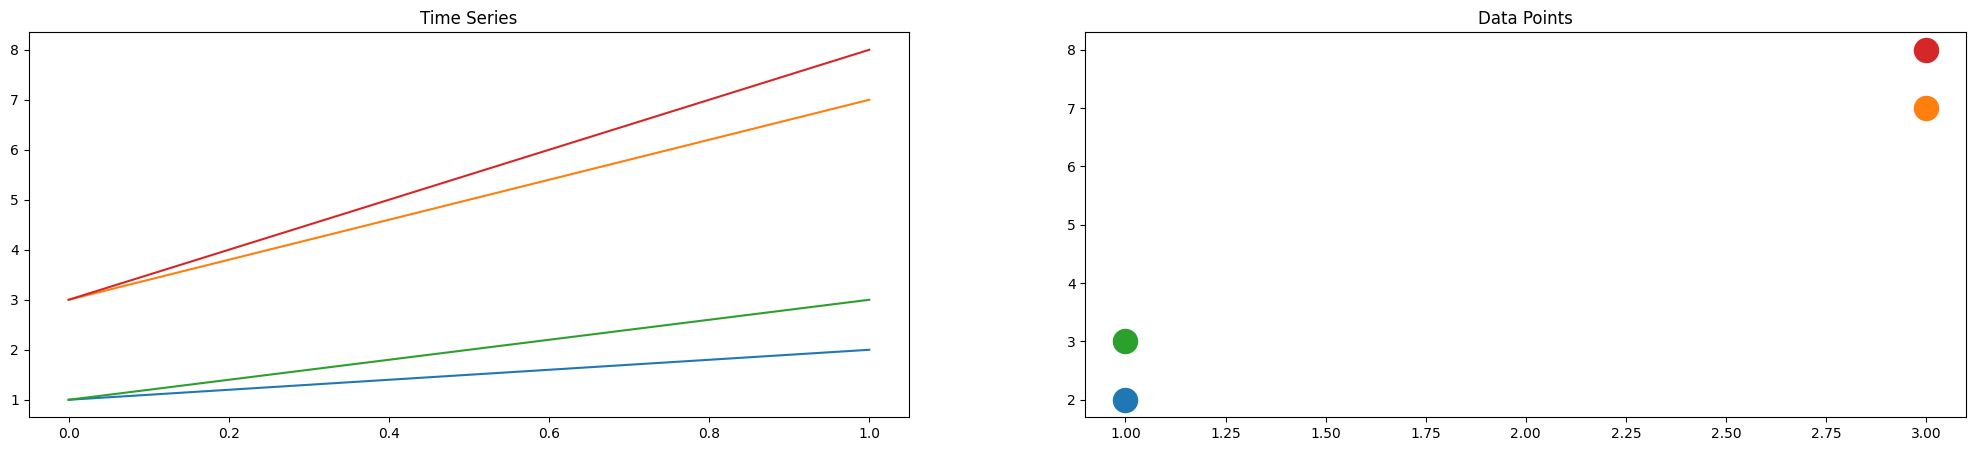

In [7]:
a = [1,2]
b = [3,7]
c = [1,3]
d = [3,8]
fig, axs = plt.subplots(1,2,figsize=(25,5))
axs[0].plot(a)
axs[0].plot(b)
axs[0].plot(c)
axs[0].plot(d)
axs[0].set_title("Time Series")
axs[1].set_title("Data Points")
axs[1].scatter(a[0],a[1], s=300)
axs[1].scatter(b[0],b[1], s=300)
axs[1].scatter(c[0],c[1], s=300)
axs[1].scatter(d[0],d[1], s=300)
plt.show()

In [38]:
bar1 = calculate_barycenter(mfcc1)
bar2 = calculate_barycenter(mfcc2)

In [42]:
tsne_reduce(bar1)

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [41]:
time_warp_dist(bar1, bar2)

11461.336238336482

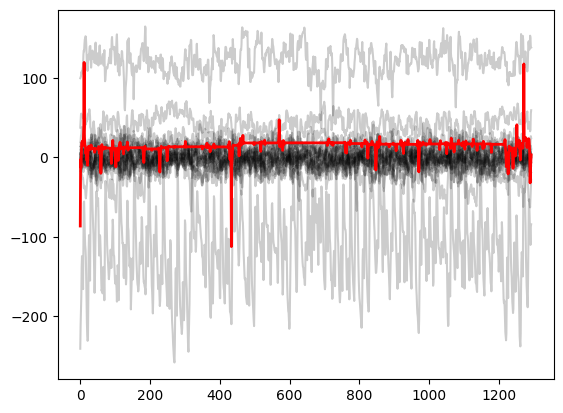

In [35]:
plot_barycenter(mfcc1)

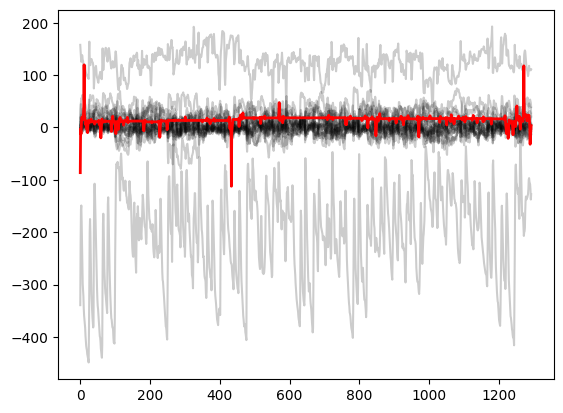

In [37]:
plot_barycenter(mfcc2)

In [1]:
from src.song import Song
from src.visualization import *
import glob

In [42]:
def iterate_music():
    genres = ['blues', 'classical']
    for genre in genres:
        arr = [path for path in glob.glob(f'./data/{genre}/*')][:10]
        for item in arr:
            yield item, genre

In [43]:
songs = []
for path, genre in iterate_music():
    songs.append(Song(genre, path))

In [44]:
genres = pd.Series(map(lambda x: x.genre, songs))

In [45]:
barycenters = pd.DataFrame(map(lambda x: x.get_barycenter().ravel(), songs))

In [47]:
barycenters['genre'] = genres

In [48]:
barycenters

,0,1,2,3,4,5,6,7,8,9,...,1305,1306,1307,1308,1309,1310,1311,1312,1313,genre
0,-3.387567,8.498879,14.965962,26.160881,16.619457,11.319807,7.496548,3.223185,0.128032,-7.629476,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,blues
1,3.087590,18.114004,7.559537,-2.306574,-9.475029,-4.748428,2.435789,-6.603823,-13.932356,-10.491481,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,blues
2,28.278934,-0.962250,-32.918913,-40.040198,-35.295618,-35.194880,-31.103092,-9.390685,3.042428,-17.132253,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,blues
3,-6.188986,74.904419,11.018509,-12.839502,-29.989755,-83.256358,-17.840398,-5.613214,3.037244,-5.873305,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,blues
4,89.513747,23.185823,-8.956959,-24.840787,-32.889379,-33.150062,-33.150062,-33.150062,-33.150062,-33.150062,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,blues
5,32.532339,104.401925,-7.406865,12.070480,-14.520453,-35.975744,-41.854341,-42.181531,-42.572217,-38.527187,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,blues
6,-25.080956,4.847978,2.518939,-5.116386,-16.610448,-48.847540,-12.648923,2.962128,44.338057,12.614419,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,blues
7,-12.630675,-4.243759,-41.011964,3.972929,15.253358,24.060492,18.162351,12.023705,27.084268,64.125092,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,blues
8,17.703011,1.940730,-6.269185,-17.690715,-41.446628,-2.134440,-10.911532,5.155663,16.982667,14.228614,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,blues
9,-9.625086,16.201998,7.033006,19.613081,38.231281,16.795436,9.817952,13.069990,11.489821,10.986611,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,blues


In [7]:
df = barycenters
feature_cols = [x for x in df.columns if isinstance(x, int)]

NameError: name 'barycenters' is not defined

In [34]:
x = df.loc[:, feature_cols]

In [8]:
from src.song import Song
other_song = Song('data/requests/req.mp3')

In [9]:
song = Song('data/blues/blues.00000.wav')
song2 = Song('data/country/country.00001.wav')

In [10]:
time_warp_dist(song2.mfcc, song.mfcc)

NameError: name 'time_warp_dist' is not defined

In [13]:
min_len = min(len(song.y), len(song2.y))

In [12]:
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
import numpy as np

x = np.array([song.y[:min_len].ravel()])
y = np.array([song2.y[:min_len].ravel()])

distance, path = fastdtw(x, y, dist=euclidean)

print(distance)

NameError: name 'min_len' is not defined

In [39]:
x.shape

(1, 661794)

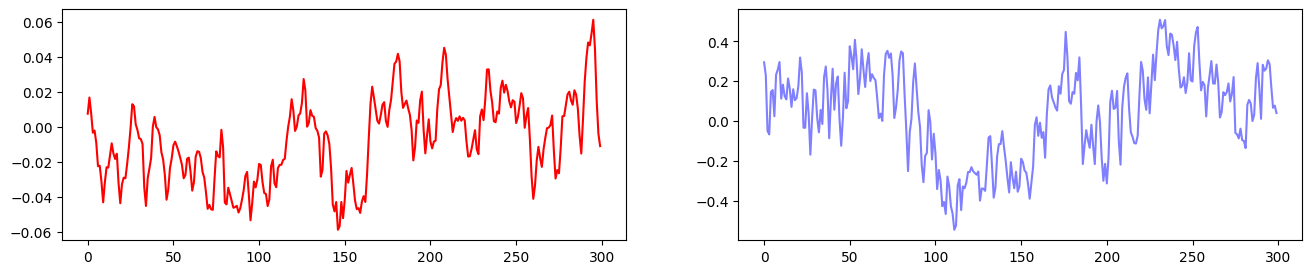

In [14]:
import matplotlib.pyplot as plt
f = plt.figure(figsize=(16,3))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax1.plot(song.y[:300], color='r')
ax2.plot(other_song.y[:300], color='b', alpha=0.5)
plt.show()

In [15]:
from src.visualization import calculate_barycenter
bars = calculate_barycenter(song.mfcc)
bars2 = calculate_barycenter(song2.mfcc)

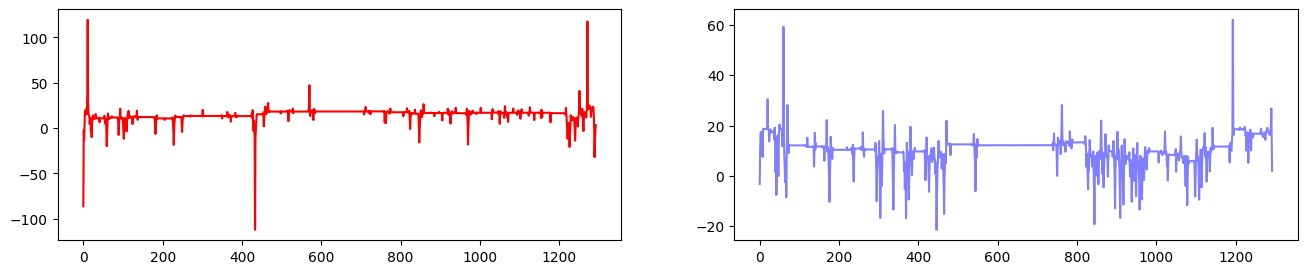

In [18]:
f = plt.figure(figsize=(16,3))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax1.plot(bars, color='r')
ax2.plot(bars2, color='b', alpha=0.5)
plt.show()